# Predictive Modeling

In [1]:
%pip install numpy==2.2.0 --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

Note: you may need to restart the kernel to use updated packages.


/home/samrawit/insurance-risk-modeling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv('../data/MachineLearningRating_v3.txt', delimiter='|')

# Target 1: Claim severity → filter only those with a claim
df_claimed = df[df['TotalClaims'] > 0].copy()

# Feature: Add HasClaim and Margin if not added before
df['HasClaim'] = df['TotalClaims'] > 0
df['Margin'] = df['TotalPremium'] - df['TotalClaims']


/tmp/ipykernel_687129/2954282808.py:2: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3.txt', delimiter='|')


Feature Engineering and Encoding

In [3]:
features = [
    'Gender', 'Province', 'VehicleType', 'RegistrationYear',
    'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm'
]
target = 'TotalClaims'


In [4]:
df_claimed = df_claimed[features + [target]].dropna()


In [5]:
df_encoded = pd.get_dummies(df_claimed, columns=['Gender', 'Province', 'VehicleType'], drop_first=True)


In [6]:
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(X_train, X_train)
y_pred_lr = lr.predict(X_test)


Random Forest Regressor

In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Claim Severity Prediction (XGBoost Regressor)

In [9]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [11]:
def evaluate(y_true, y_pred, name):
    import numpy as np
    from sklearn.metrics import mean_squared_error, r2_score

    # Ensure both are 1D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.2f}")


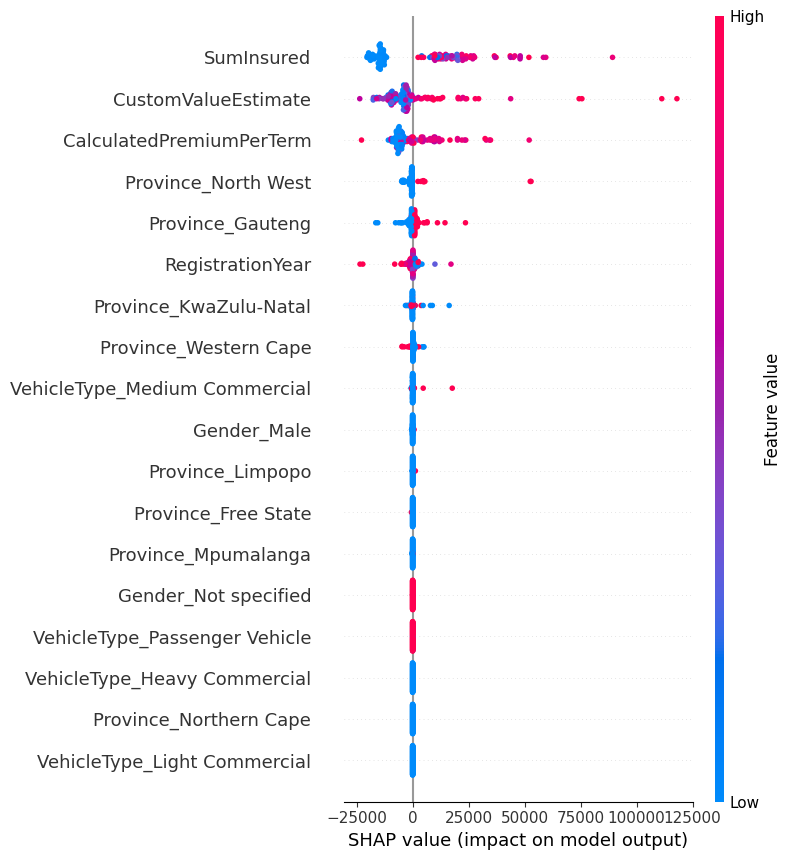

In [12]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [14]:
import os
import matplotlib.pyplot as plt

os.makedirs("../plots", exist_ok=True)

# Save SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("../plots/shap_summary_plot.png", bbox_inches="tight")
plt.close()